In [2]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [3]:
dataset_path = r"/home/sheeru/Documents/ML Datasets/music/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [10]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            # print(f"Processing: {semantic_label}")

            # process files for specific genre
            for f in filenames:
                if f == str("jazz.00054.wav"):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            # print(f"{file_path}, segment: {s+1}")

                        else:
                            print(file_path, len(mfcc), expected_vects_ps)

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [11]:
save_mfcc(dataset_path,json_path,num_segments=10)
# clear_output()

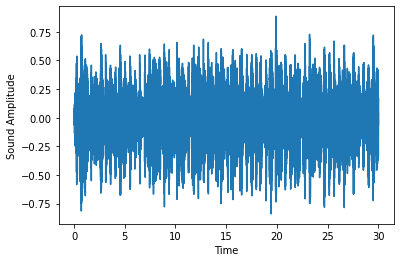

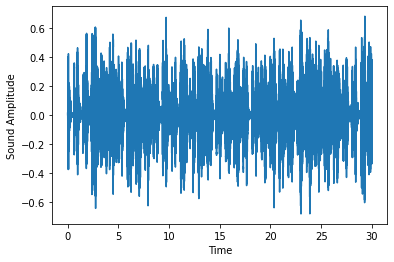

In [15]:
filepath = r"/home/sheeru/Documents/ML Datasets/music/genres_original/blues/blues.0000"
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

In [7]:
import json
import numpy as np

# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

inputs,targets = load_data(r"./data.json")
print(len(targets))

9986


In [10]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()
model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


2021-11-22 19:22:05.207753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 19:22:05.259687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-22 19:22:05.259706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-22 19:22:05.260117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [7]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

<Figure size 1440x1080 with 0 Axes>

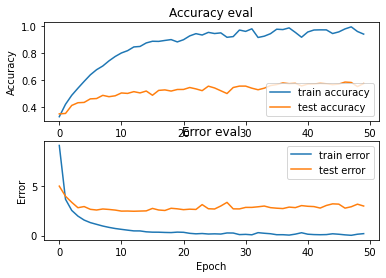

In [8]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
plot_history(hist)

In [9]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 1ms/step - loss: 2.9916 - accuracy: 0.5748
Test accuracy: 0.5747663378715515


In [10]:
import tensorflow.keras as keras
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

<Figure size 1440x1080 with 0 Axes>

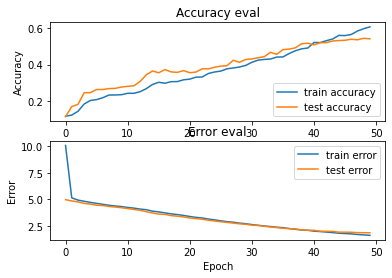

In [11]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()
plot_history(hist)

In [12]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 1.8324 - accuracy: 0.5404
Test accuracy: 0.5403871536254883


In [4]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

NameError: name 'load_data' is not defined

In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [15]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 [==============================] - 11s 54ms/step - loss: 2.1264 - accuracy: 0.2712 - val_loss: 1.7562 - val_accuracy: 0.3652

<Figure size 1440x1080 with 0 Axes>

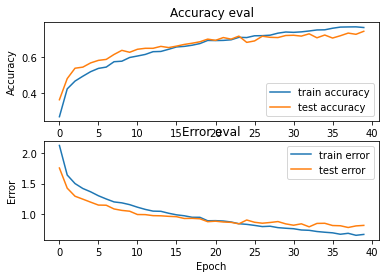

In [16]:
plot_history(hist)

In [5]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

NameError: name 'model' is not defined

In [18]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")
predict(model, X_test[10], y_test[10])

Expected index: 6, Predicted index: [2]


In [11]:
X_multi,y = load_data(r"./data.json")
print(X_multi.shape, len(y))
X = list()
for row_index in range(X_multi.shape[0]):
    X.append(X_multi[row_index].flatten())

X = np.array(X)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

(9986, 130, 13) 9986
(9986, 1690)


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
def get_classification_measures(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_true, y_pred, average='weighted'))
    print("---------------------------------------------------")
    for output_class in np.unique(y_true):
        print("Output Class: ", output_class)
        y_true_bin = list()
        y_pred_bin = list()
        for y_val in y_true:
            if y_val == output_class:
                y_true_bin.append(1)
            else:
                y_true_bin.append(0)

        for y_val in y_pred:
            if y_val == output_class:
                y_pred_bin.append(1)
            else:
                y_pred_bin.append(0)

        print('Accuracy: ', accuracy_score(y_true_bin, y_pred_bin))
        print('Precision: ', precision_score(y_true_bin, y_pred_bin))
        print('Recall: ', recall_score(y_true_bin, y_pred_bin))
        print('F1: ', f1_score(y_true_bin, y_pred_bin))
        print("ROC Curve")
        FPR, TPR, thresholds = roc_curve(y_true_bin, y_pred_bin)
        plt.plot(FPR, TPR)
        plt.show()
        print('ROC AUC: ', roc_auc_score(y_true_bin, y_pred_bin))
        print('Confusion Matrix: \n', confusion_matrix(y_true_bin, y_pred_bin))
        print("---------------------------------------------------")

Logistic Regression
Accuracy:  0.4535800970873786
Precision:  0.43713784020802005
Recall:  0.4535800970873786
---------------------------------------------------
Output Class:  0
Accuracy:  0.8722694174757282
Precision:  0.30714285714285716
Recall:  0.2747603833865815
F1:  0.2900505902192243
ROC Curve


/mnt/Academics/repos/music-genre/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


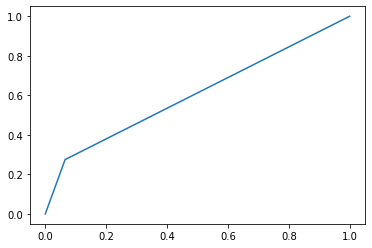

ROC AUC:  0.6048625919614772
Confusion Matrix: 
 [[2789  194]
 [ 227   86]]
---------------------------------------------------
Output Class:  1
Accuracy:  0.8737864077669902
Precision:  0.32247557003257327
Recall:  0.32247557003257327
F1:  0.32247557003257327
ROC Curve


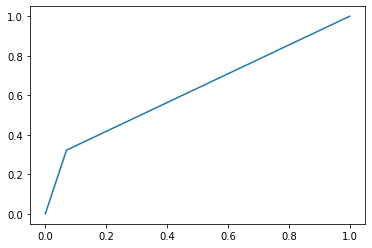

ROC AUC:  0.6264435394492074
Confusion Matrix: 
 [[2781  208]
 [ 208   99]]
---------------------------------------------------
Output Class:  2
Accuracy:  0.9484223300970874
Precision:  0.7124352331606217
Recall:  0.8233532934131736
F1:  0.763888888888889
ROC Curve


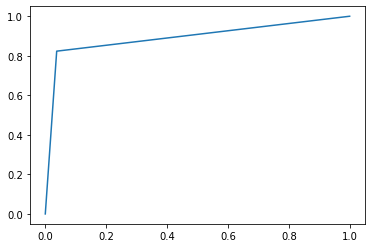

ROC AUC:  0.8929393070712055
Confusion Matrix: 
 [[2851  111]
 [  59  275]]
---------------------------------------------------
Output Class:  3
Accuracy:  0.8865291262135923
Precision:  0.43354430379746833
Recall:  0.4126506024096386
F1:  0.4228395061728395
ROC Curve


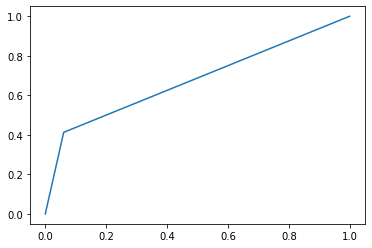

ROC AUC:  0.6761296196933483
Confusion Matrix: 
 [[2785  179]
 [ 195  137]]
---------------------------------------------------
Output Class:  4
Accuracy:  0.8613470873786407
Precision:  0.26373626373626374
Recall:  0.21951219512195122
F1:  0.2396006655574043
ROC Curve


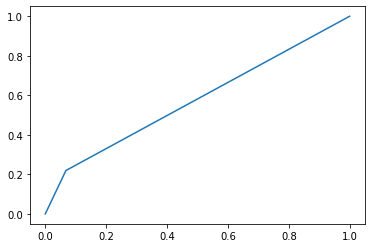

ROC AUC:  0.5758949115771481
Confusion Matrix: 
 [[2767  201]
 [ 256   72]]
---------------------------------------------------
Output Class:  5
Accuracy:  0.9365898058252428
Precision:  0.665680473372781
Recall:  0.7009345794392523
F1:  0.6828528072837632
ROC Curve


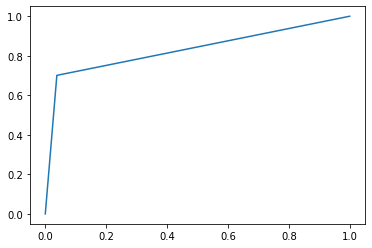

ROC AUC:  0.8314756930809707
Confusion Matrix: 
 [[2862  113]
 [  96  225]]
---------------------------------------------------
Output Class:  6
Accuracy:  0.8789441747572816
Precision:  0.3527272727272727
Recall:  0.3050314465408805
F1:  0.327150084317032
ROC Curve


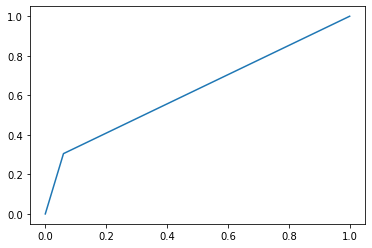

ROC AUC:  0.6226298938547249
Confusion Matrix: 
 [[2800  178]
 [ 221   97]]
---------------------------------------------------
Output Class:  7
Accuracy:  0.8534587378640777
Precision:  0.3139240506329114
Recall:  0.36904761904761907
F1:  0.3392612859097127
ROC Curve


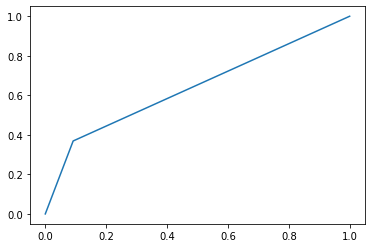

ROC AUC:  0.6387467824967825
Confusion Matrix: 
 [[2689  271]
 [ 212  124]]
---------------------------------------------------
Output Class:  8
Accuracy:  0.8616504854368932
Precision:  0.2907801418439716
Recall:  0.24260355029585798
F1:  0.264516129032258
ROC Curve


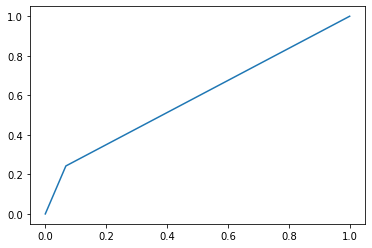

ROC AUC:  0.5874951490492136
Confusion Matrix: 
 [[2758  200]
 [ 256   82]]
---------------------------------------------------
Output Class:  9
Accuracy:  0.9341626213592233
Precision:  0.6711711711711712
Recall:  0.8075880758807588
F1:  0.7330873308733088
ROC Curve


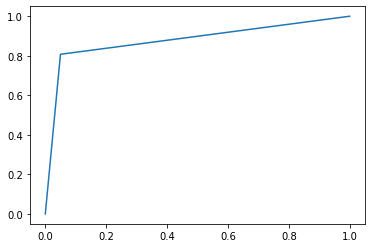

ROC AUC:  0.8788538261194022
Confusion Matrix: 
 [[2781  146]
 [  71  298]]
---------------------------------------------------


In [60]:
from sklearn.linear_model import LogisticRegression
def logistic_regression(X_train, y_train, X_test, y_test):
    print("Logistic Regression")
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    get_classification_measures(y_test, y_pred)

logistic_regression(X_train, y_train, X_test, y_test)

Naive Bayes
Accuracy:  0.4117111650485437
Precision:  0.41120050236294553
Recall:  0.4117111650485437
---------------------------------------------------
Output Class:  0
Accuracy:  0.8956310679611651
Precision:  0.21818181818181817
Recall:  0.038338658146964855
F1:  0.06521739130434782
ROC Curve


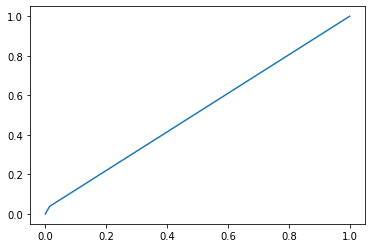

ROC AUC:  0.5119618198545753
Confusion Matrix: 
 [[2940   43]
 [ 301   12]]
---------------------------------------------------
Output Class:  1
Accuracy:  0.9010922330097088
Precision:  0.4605809128630705
Recall:  0.36156351791530944
F1:  0.4051094890510949
ROC Curve


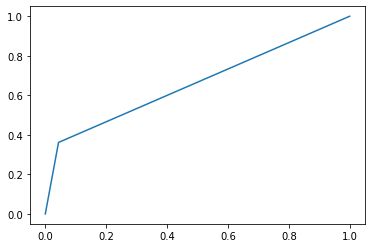

ROC AUC:  0.6590353554782301
Confusion Matrix: 
 [[2859  130]
 [ 196  111]]
---------------------------------------------------
Output Class:  2
Accuracy:  0.9520631067961165
Precision:  0.7528735632183908
Recall:  0.7844311377245509
F1:  0.7683284457478006
ROC Curve


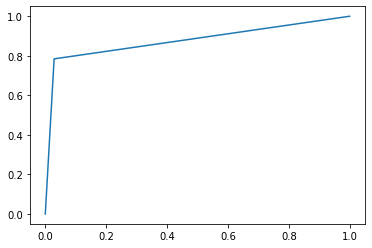

ROC AUC:  0.8776983507663945
Confusion Matrix: 
 [[2876   86]
 [  72  262]]
---------------------------------------------------
Output Class:  3
Accuracy:  0.8795509708737864
Precision:  0.38434163701067614
Recall:  0.3253012048192771
F1:  0.3523654159869495
ROC Curve


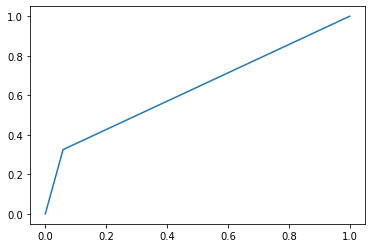

ROC AUC:  0.6334670666471555
Confusion Matrix: 
 [[2791  173]
 [ 224  108]]
---------------------------------------------------
Output Class:  4
Accuracy:  0.8610436893203883
Precision:  0.19339622641509435
Recall:  0.125
F1:  0.15185185185185185
ROC Curve


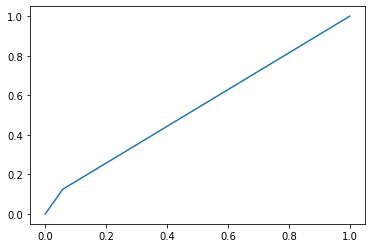

ROC AUC:  0.5336927223719676
Confusion Matrix: 
 [[2797  171]
 [ 287   41]]
---------------------------------------------------
Output Class:  5
Accuracy:  0.8343446601941747
Precision:  0.3595505617977528
Recall:  0.897196261682243
F1:  0.5133689839572192
ROC Curve


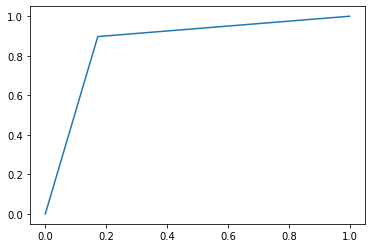

ROC AUC:  0.8623796434461636
Confusion Matrix: 
 [[2462  513]
 [  33  288]]
---------------------------------------------------
Output Class:  6
Accuracy:  0.9013956310679612
Precision:  0.4533333333333333
Recall:  0.1069182389937107
F1:  0.17302798982188294
ROC Curve


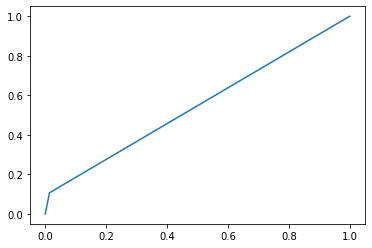

ROC AUC:  0.5465753048561568
Confusion Matrix: 
 [[2937   41]
 [ 284   34]]
---------------------------------------------------
Output Class:  7
Accuracy:  0.8398058252427184
Precision:  0.26
Recall:  0.30952380952380953
F1:  0.2826086956521739
ROC Curve


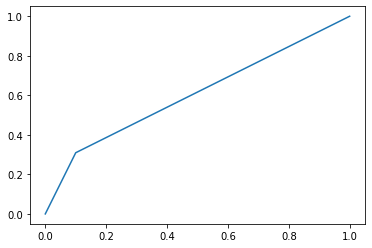

ROC AUC:  0.6047619047619048
Confusion Matrix: 
 [[2664  296]
 [ 232  104]]
---------------------------------------------------
Output Class:  8
Accuracy:  0.9038228155339806
Precision:  0.5867768595041323
Recall:  0.21005917159763313
F1:  0.3093681917211329
ROC Curve


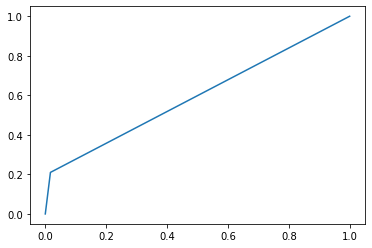

ROC AUC:  0.5965779292741378
Confusion Matrix: 
 [[2908   50]
 [ 267   71]]
---------------------------------------------------
Output Class:  9
Accuracy:  0.8546723300970874
Precision:  0.42782152230971127
Recall:  0.8834688346883469
F1:  0.5764809902740937
ROC Curve


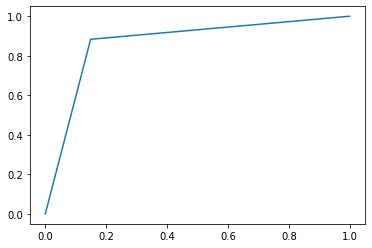

ROC AUC:  0.8672554286185159
Confusion Matrix: 
 [[2491  436]
 [  43  326]]
---------------------------------------------------


In [61]:
from sklearn.naive_bayes import GaussianNB
def custom_naive_bayes(X_train, y_train, X_test, y_test):
    print("Naive Bayes")
    gnb = GaussianNB()
    naive_bayes_model = gnb.fit(X_train, y_train)
    y_pred = naive_bayes_model.predict(X_test)
    get_classification_measures(y_test, y_pred)

custom_naive_bayes(X_train, y_train, X_test, y_test)

Decision Tree
Accuracy:  0.3586165048543689
Precision:  0.36175044148456714
Recall:  0.3586165048543689
---------------------------------------------------
Output Class:  0
Accuracy:  0.8431432038834952
Precision:  0.211864406779661
Recall:  0.23961661341853036
F1:  0.22488755622188905
ROC Curve


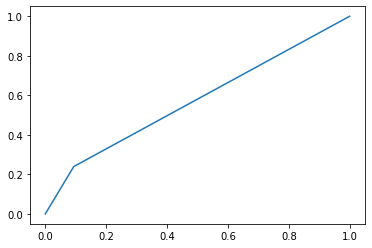

ROC AUC:  0.5730433050331003
Confusion Matrix: 
 [[2704  279]
 [ 238   75]]
---------------------------------------------------
Output Class:  1
Accuracy:  0.8516383495145631
Precision:  0.2275449101796407
Recall:  0.247557003257329
F1:  0.23712948517940716
ROC Curve


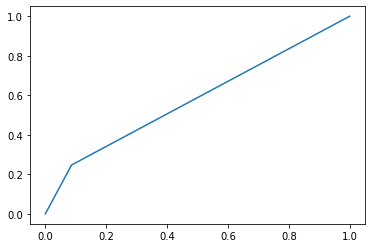

ROC AUC:  0.5806202547233451
Confusion Matrix: 
 [[2731  258]
 [ 231   76]]
---------------------------------------------------
Output Class:  2
Accuracy:  0.9338592233009708
Precision:  0.6686046511627907
Recall:  0.688622754491018
F1:  0.6784660766961651
ROC Curve


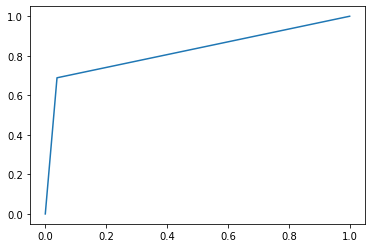

ROC AUC:  0.8250676230253874
Confusion Matrix: 
 [[2848  114]
 [ 104  230]]
---------------------------------------------------
Output Class:  3
Accuracy:  0.8637742718446602
Precision:  0.3342776203966006
Recall:  0.35542168674698793
F1:  0.3445255474452555
ROC Curve


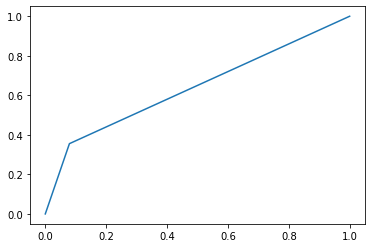

ROC AUC:  0.638068468204803
Confusion Matrix: 
 [[2729  235]
 [ 214  118]]
---------------------------------------------------
Output Class:  4
Accuracy:  0.8455703883495146
Precision:  0.22492401215805471
Recall:  0.22560975609756098
F1:  0.2252663622526636
ROC Curve


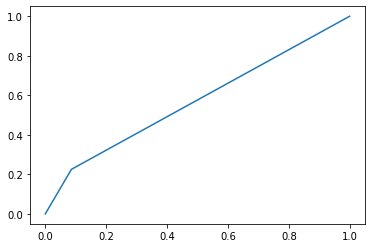

ROC AUC:  0.5698466570245218
Confusion Matrix: 
 [[2713  255]
 [ 254   74]]
---------------------------------------------------
Output Class:  5
Accuracy:  0.9050364077669902
Precision:  0.512987012987013
Recall:  0.49221183800623053
F1:  0.5023847376788553
ROC Curve


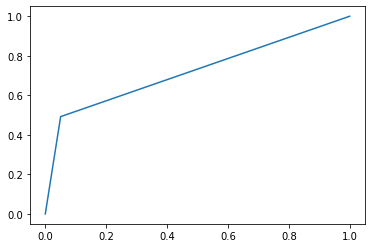

ROC AUC:  0.7208958349695018
Confusion Matrix: 
 [[2825  150]
 [ 163  158]]
---------------------------------------------------
Output Class:  6
Accuracy:  0.8507281553398058
Precision:  0.22981366459627328
Recall:  0.23270440251572327
F1:  0.23125
ROC Curve


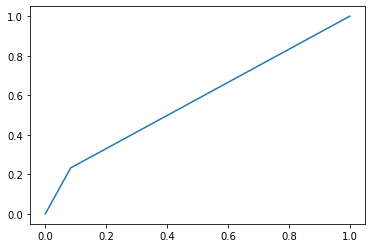

ROC AUC:  0.5747135175775393
Confusion Matrix: 
 [[2730  248]
 [ 244   74]]
---------------------------------------------------
Output Class:  7
Accuracy:  0.8546723300970874
Precision:  0.28134556574923547
Recall:  0.27380952380952384
F1:  0.277526395173454
ROC Curve


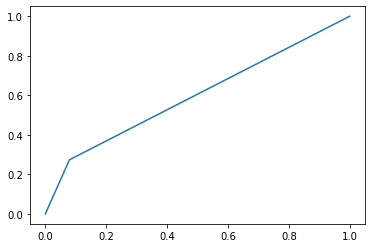

ROC AUC:  0.5972088159588159
Confusion Matrix: 
 [[2725  235]
 [ 244   92]]
---------------------------------------------------
Output Class:  8
Accuracy:  0.8552791262135923
Precision:  0.254416961130742
Recall:  0.21301775147928995
F1:  0.23188405797101447
ROC Curve


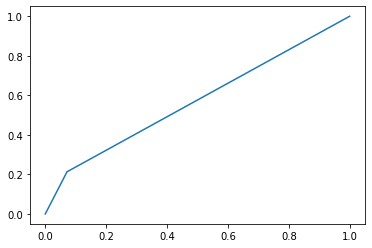

ROC AUC:  0.5708428852055003
Confusion Matrix: 
 [[2747  211]
 [ 266   72]]
---------------------------------------------------
Output Class:  9
Accuracy:  0.9135315533980582
Precision:  0.6228070175438597
Recall:  0.5772357723577236
F1:  0.5991561181434599
ROC Curve


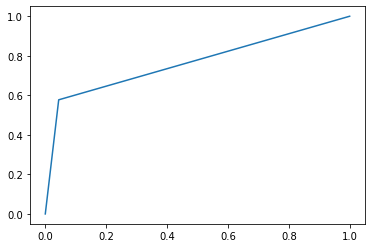

ROC AUC:  0.7665816716247108
Confusion Matrix: 
 [[2798  129]
 [ 156  213]]
---------------------------------------------------


In [62]:
from sklearn import tree
def decision_tree(X_train, y_train, X_test, y_test):
    print("Decision Tree")
    clf = tree.DecisionTreeClassifier()
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    get_classification_measures(y_test, y_pred)

decision_tree(X_train, y_train, X_test, y_test)

In [1]:
from sklearn.neighbors import KNeighborsClassifier
def knn(k, X_train, y_train, X_test, y_test):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    get_classification_measures(y_test, y_pred)
knn(5, X_train, y_train, X_test, y_test)

NameError: name 'X_train' is not defined

kernel function: rbf
Accuracy:  0.5518810679611651
Precision:  0.5407014717851545
Recall:  0.5518810679611651
---------------------------------------------------
Output Class:  0
Accuracy:  0.8837985436893204
Precision:  0.41812865497076024
Recall:  0.43730886850152906
F1:  0.4275037369207773
ROC Curve


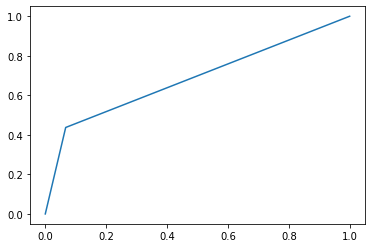

ROC AUC:  0.6851414669216975
Confusion Matrix: 
 [[2770  199]
 [ 184  143]]
---------------------------------------------------
Output Class:  1
Accuracy:  0.9044296116504854
Precision:  0.49693251533742333
Recall:  0.5175718849840255
F1:  0.5070422535211266
ROC Curve


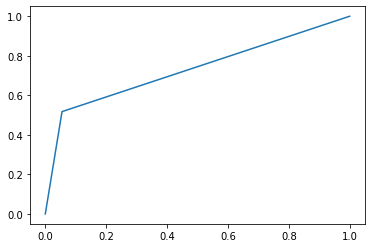

ROC AUC:  0.7312968375640878
Confusion Matrix: 
 [[2819  164]
 [ 151  162]]
---------------------------------------------------
Output Class:  2
Accuracy:  0.964502427184466
Precision:  0.7956989247311828
Recall:  0.8783382789317508
F1:  0.8349788434414669
ROC Curve


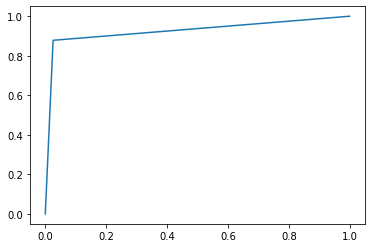

ROC AUC:  0.9263269630549258
Confusion Matrix: 
 [[2883   76]
 [  41  296]]
---------------------------------------------------
Output Class:  3
Accuracy:  0.9177791262135923
Precision:  0.568733153638814
Recall:  0.65527950310559
F1:  0.6089466089466089
ROC Curve


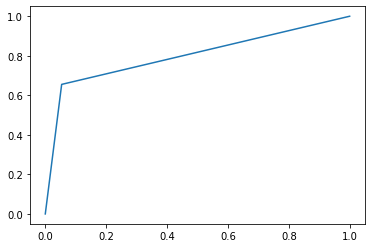

ROC AUC:  0.8007399533012819
Confusion Matrix: 
 [[2814  160]
 [ 111  211]]
---------------------------------------------------
Output Class:  4
Accuracy:  0.8783373786407767
Precision:  0.3840304182509506
Recall:  0.29705882352941176
F1:  0.3349917081260365
ROC Curve


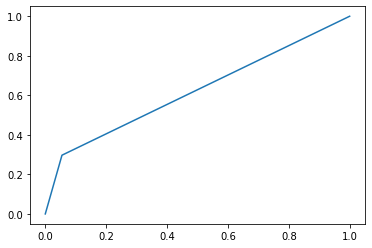

ROC AUC:  0.6211275173127438
Confusion Matrix: 
 [[2794  162]
 [ 239  101]]
---------------------------------------------------
Output Class:  5
Accuracy:  0.9174757281553398
Precision:  0.5601659751037344
Recall:  0.8181818181818182
F1:  0.665024630541872
ROC Curve


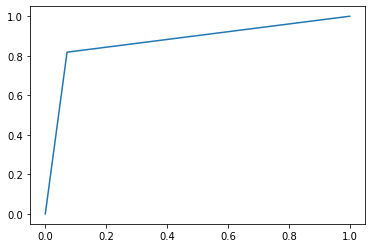

ROC AUC:  0.8733525409182862
Confusion Matrix: 
 [[2754  212]
 [  60  270]]
---------------------------------------------------
Output Class:  6
Accuracy:  0.9053398058252428
Precision:  0.5208333333333334
Recall:  0.38819875776397517
F1:  0.4448398576512456
ROC Curve


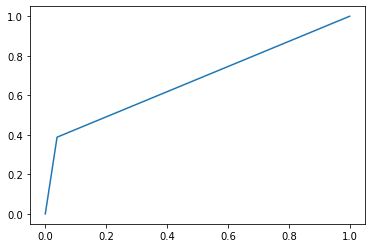

ROC AUC:  0.6747651488887125
Confusion Matrix: 
 [[2859  115]
 [ 197  125]]
---------------------------------------------------
Output Class:  7
Accuracy:  0.8989684466019418
Precision:  0.5122950819672131
Recall:  0.3687315634218289
F1:  0.42881646655231553
ROC Curve


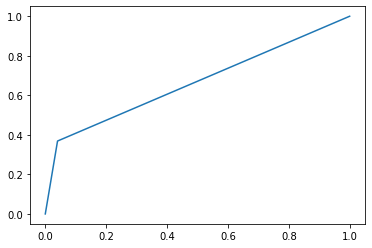

ROC AUC:  0.664244036699078
Confusion Matrix: 
 [[2838  119]
 [ 214  125]]
---------------------------------------------------
Output Class:  8
Accuracy:  0.9026092233009708
Precision:  0.5244444444444445
Recall:  0.35542168674698793
F1:  0.4236983842010772
ROC Curve


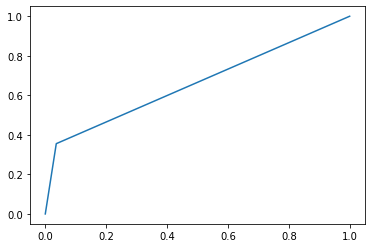

ROC AUC:  0.6596609108498772
Confusion Matrix: 
 [[2857  107]
 [ 214  118]]
---------------------------------------------------
Output Class:  9
Accuracy:  0.9305218446601942
Precision:  0.6218097447795824
Recall:  0.8023952095808383
F1:  0.7006535947712419
ROC Curve


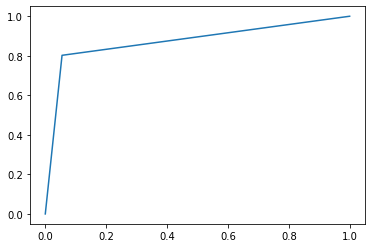

ROC AUC:  0.8736824123528769
Confusion Matrix: 
 [[2799  163]
 [  66  268]]
---------------------------------------------------


In [14]:
from sklearn import svm
def custom_svm(x_train, y_train, x_test, y_test, kernel):
    print("kernel function:", kernel)
    svm_model = svm.SVC(kernel=kernel)
    svm_model.fit(x_train,y_train)
    y_pred = svm_model.predict(x_test)
    get_classification_measures(y_test, y_pred)

custom_svm(X_train, y_train, X_test, y_test, "linear")
custom_svm(X_train, y_train, X_test, y_test, "poly")
custom_svm(X_train, y_train, X_test, y_test, "sigmoid")
custom_svm(X_train, y_train, X_test, y_test, "rbf")
